## Hyperparameter Tuning

Machine learning models consist of model parameters (coefficients iteratively learned through training on the data) and hyperparameters (values set by the user prior to training). While guidelines for hyperparameters exist, identifying the optimal values for a given model *a priori* is not feasible. Thus we must search a combination of possible hyperparameters to identify the optimal values. This can be done using several approaches.

### Grid Search

This brute force approach samples all parameters across a range at equal intervals. While comprehensive in principle, it is the least efficient approach to identifying hyperparameters. The search space quickly becomes intractable. 

### Random Search 

Generates a random subset of hyperparameters to test. While this is more computationally efficient than grid search, it does not evenly sample space and can result in suboptimal parameters. 

### Bayesian Optimization

The preferred approach for most circumstances, Bayesian hyperparameter tuning optimizes a specified metric (AUC, accuracy, F1, etc.) obtained from the current hyperparameter selection. Treating the model like a black box and the hyperparameter selection as inputs, the output (metric) is measured and used to estimate the next best set of hyperparameters likely to result in an improved metric. This allows us to define our problem as 

posterior = likelihood x prior

The posterior represents the probability of our metric given the hyperparameter, while the likelihood is the probability of the hyperparameters given the metric and the likelihood is the probability of the metric. By collecting the distribution of calculated metrics and hyperparameters and using a surogate function, the posterior can be optimized resulting in the optimal hyperparameters being identified. 

For more information see https://scikit-learn.org/stable/modules/grid_search.html, https://scikit-optimize.github.io/stable/ and https://en.wikipedia.org/wiki/Bayesian_optimization

In [1]:
import pandas as pd
import os
import numpy as np
import json
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from skopt.callbacks import DeltaYStopper
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import log_loss, roc_auc_score, precision_score, recall_score, accuracy_score, \
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [2]:
os_platform = sys.platform

if os_platform == 'windows':
    RootDir = '\\'.join(os.getcwd().split('\\')[0:-2])
else:
    RootDir = '/'.join(os.getcwd().split('/')[0:-2])
os.chdir(RootDir)

In [3]:
%run "./notebooks/common/function_library.ipynb"

In [4]:
train_impute = pd.read_csv('data/train_smote.csv')
test_impute = pd.read_csv('data/test_impute.csv')

In [5]:
train_features = train_impute.columns[1:]
target_feature = 'readmit_flag'

# Get X/y
X_train = train_impute[train_features]
X_test = test_impute[train_features]
y_train = train_impute[target_feature]
y_test = test_impute[target_feature]

### Random Forest and other Ensemble Models

Here we use the random forest classifier to identify patients at risk of readmissions. The random forest algorithm is one of many ensemble algorithms based on tree methods. In a single decision tree, each node can be assigned weights and data passed along these branching structures based on their weights. Individiual decision trees are highly biased and do not perform well. However, many of these trees can be combined together into an ensemble and the net result can be used to make predictions that are better than any of the individual trees can achieve. An illustration of this is shown below.

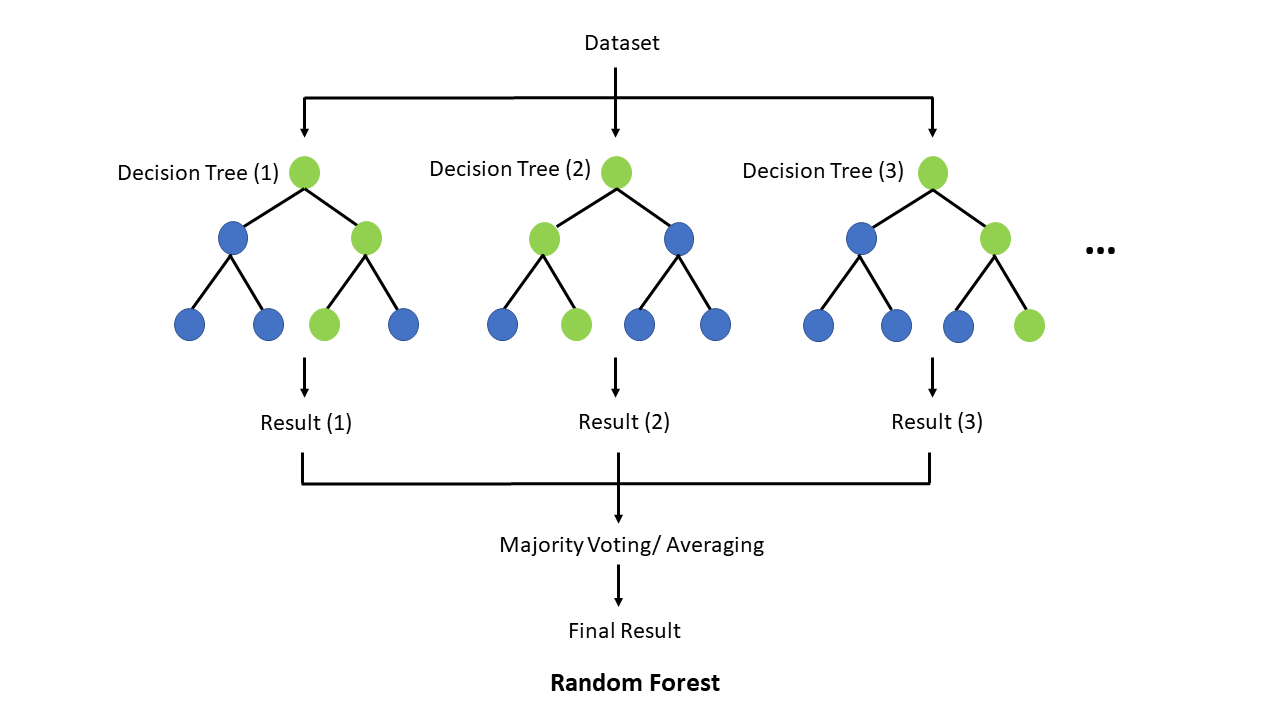

For more see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [6]:
# Read in the input parameters for random forest. 
with open('input/rf_params.json','r') as f:
    param_dict = json.load(f)

param_dict = BuildSamplingDict(param_dict)

estimator = RandomForestClassifier()

In [7]:
# This helper function tunes the hyperparameters. 
rf_opt = TuneHyperParameters(
    X_train=X_train, y_train=y_train, estimator=estimator,param_dict=param_dict)

In [8]:
test_score = EvaluateModel(X_test=X_test,y_test=y_test,estimator=rf_opt)
print(test_score)

0.5616622677638048


### Standard Evaluation Metrics

Metrics often used for binary classification in machine learning are

Accuracy: Calculated as Total matched / total computed 
AUC: Integral of the ROC-Curve
Precision: true positive / ( true positive + false positive) looks to minimize false positives
Recall: true positive / ( true positive + false negative) looks to minimize false negatives
F1 Score: The harmonic mean of precision and recall
logloss: L = -(ylog(p) + (1-y)log(1-p). Also known as the cross-entropy loss. Commonly used in neural netoworks and deep learning applications. 
PPV: Also known as precision
NPV: true negative / (true negative + false negative)
True Negative: Number of labeled negatives identified as negative.
False Positive: Number of labeled negatives identified as positive.
False Negative: Number of labeled positives identified as negative.
True Positive: Number of labeled positives identified as positive.

For more information see https://scikit-learn.org/stable/modules/model_evaluation.html 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy: 0.8872427983539095
F1 Score: 0.04861111111111111
AUC: 0.5616622677638048
Precision: 0.030303030303030304
Recall: 0.12280701754385964
logloss: 4.064181493258477
PPV: 0.030303030303030304
NPV: 0.977262391996362
True Negative: 2149
False Positive: 224
False Negative: 50
True Positive: 7


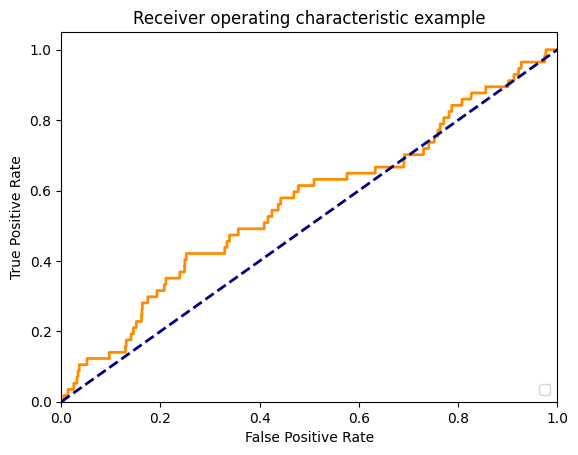

In [9]:
LogMetrics(rf_opt,X_test, y_test)